# imports

In [50]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
# import seaborn as sns; sns.set_theme(font='Malgun Gothic')

# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings; warnings.filterwarnings(action='ignore')

# 숫자 잘린거 다 보여주기
pd.options.display.float_format = '{:.5f}'.format

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

In [51]:
import statsmodels
statsmodels.__version__ # 0.12.2

'0.12.2'

# read

In [52]:
df = pd.read_csv('./cac.csv')

# ARIMA

In [53]:
df['Change']    = df['Close'].pct_change()
df['STDEV']     = df['Close'].rolling(window=20).std(ddof=0) 
df['STDEV_log'] = np.log(df['Close'].rolling(window=20).std(ddof=0))
df['HV']        = df['Change'].rolling(window=20, center=False).std() * (252 ** 0.5)

In [54]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV_log,STDEV
4822,2021-11-08,7067.10010,7037.66992,7041.60010,7047.47998,66513600.00000,7047.47998,0.00095,4.94257,0.08512
4823,2021-11-09,7079.58008,7016.72998,7023.58008,7043.27002,71276900.00000,7043.27002,-0.00060,4.93782,0.08263
4824,2021-11-10,7053.27002,7014.93994,7046.16992,7045.16016,85630200.00000,7045.16016,0.00027,4.93582,0.08214
4825,2021-11-11,7072.62988,7032.35010,7038.83984,7059.54980,74342900.00000,7059.54980,0.00204,4.96291,0.07318
4826,2021-11-12,7097.45996,7056.93018,7062.54004,7091.39990,64249000.00000,7091.39990,0.00451,5.00343,0.07227


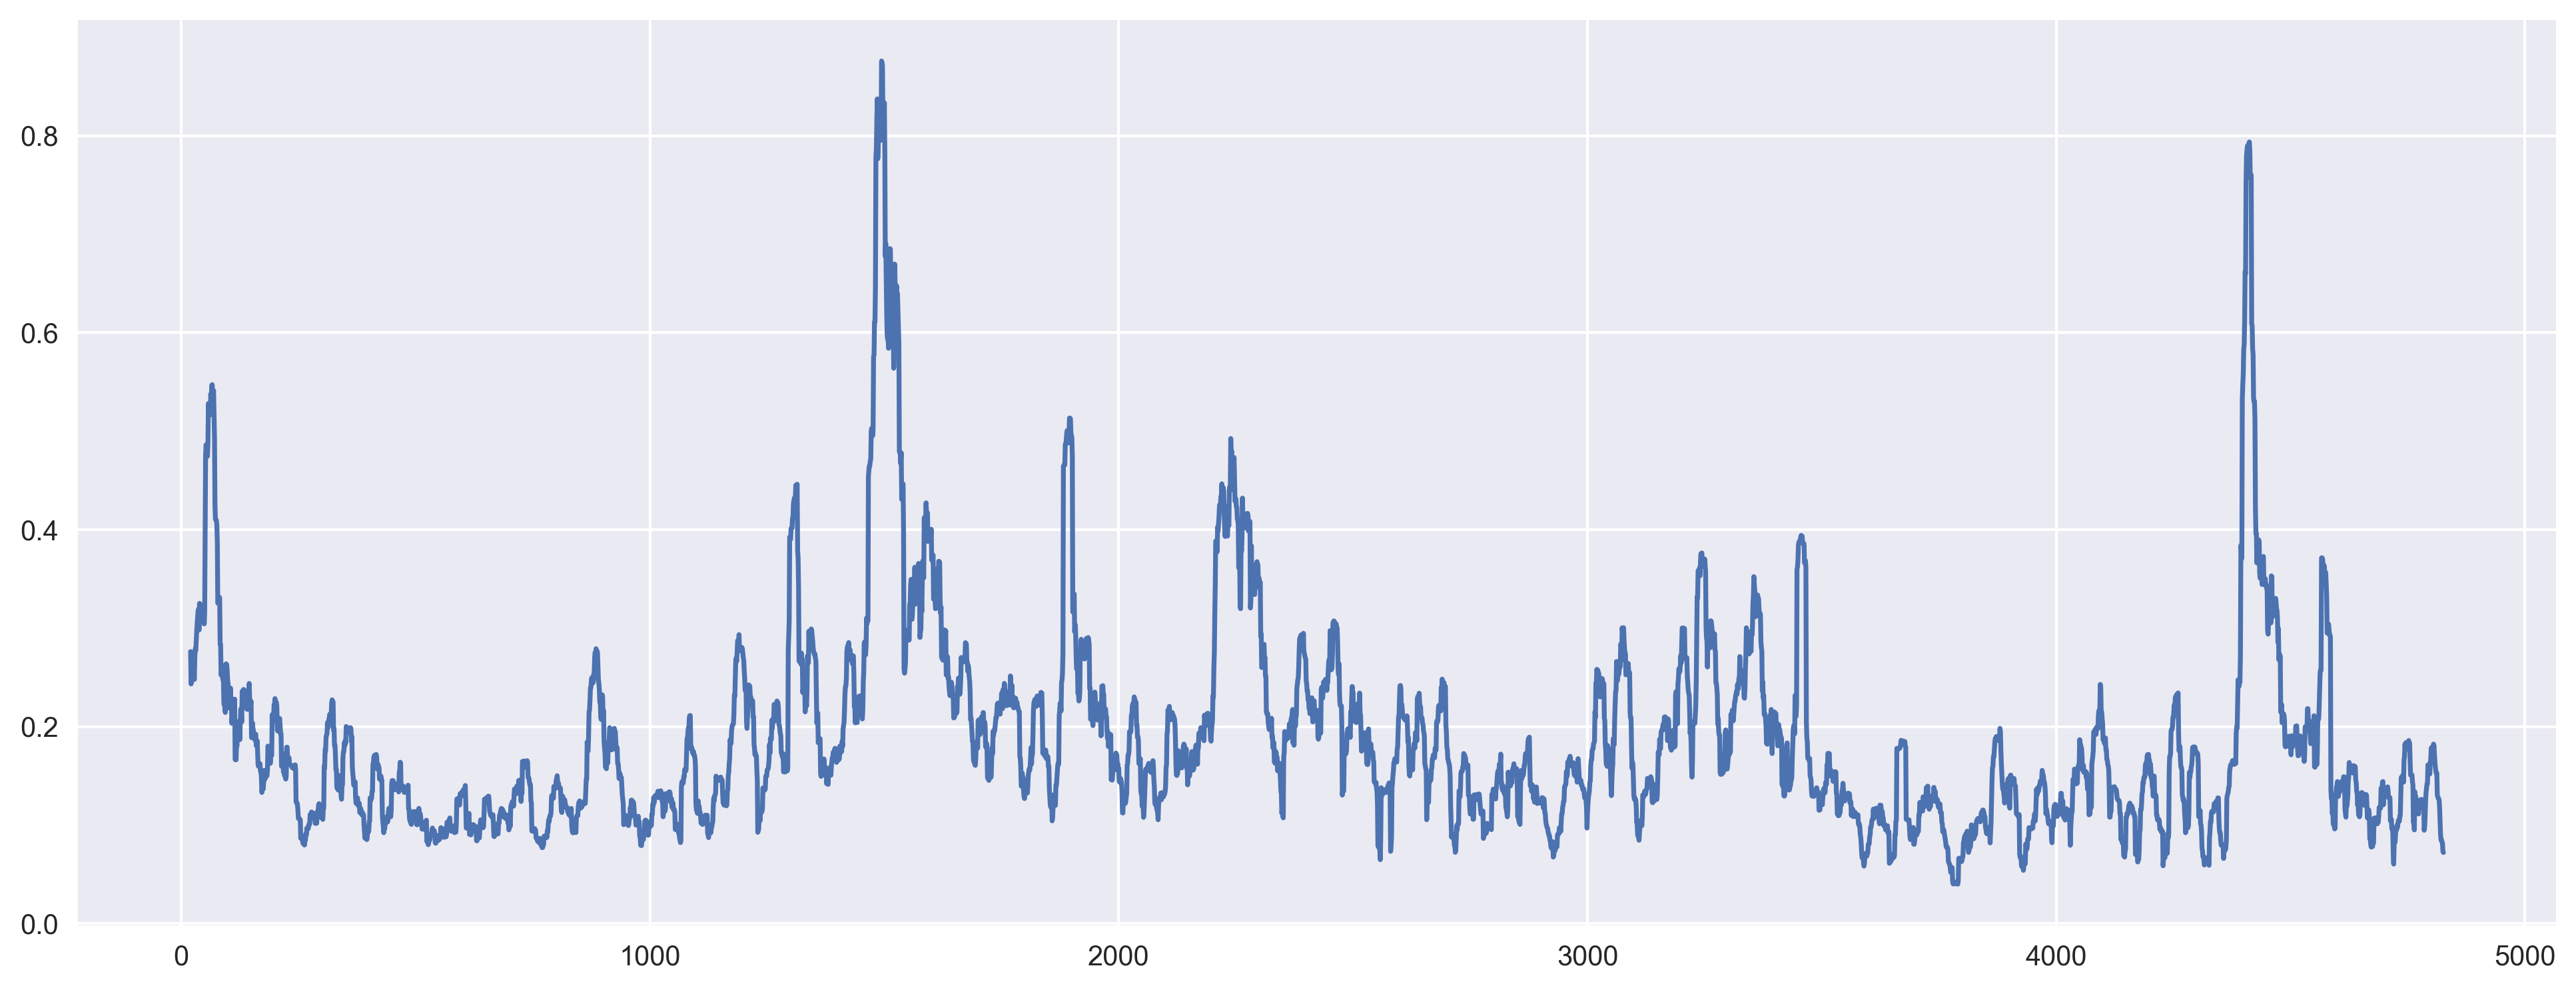

In [55]:
plt.figure(figsize=(16,6))
df['STDEV'].plot() # STDEV_log, HV
plt.show()

In [56]:
# nan 값 삭제
df = df.dropna()

In [57]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,STDEV_log,STDEV
20,2003-01-29,2840.09009,2733.51001,2792.06006,2840.05005,0.00000,2840.05005,0.01428,4.92327,0.27622
21,2003-01-30,2920.64990,2860.73999,2866.51001,2914.12988,0.00000,2914.12988,0.02608,4.91590,0.24338
22,2003-01-31,2943.15991,2847.97998,2865.23999,2937.87988,0.00000,2937.87988,0.00815,4.89434,0.24741
23,2003-02-03,2983.98999,2941.44995,2973.92993,2957.79004,0.00000,2957.79004,0.00678,4.84596,0.24727
24,2003-02-04,2937.90991,2861.41992,2934.17993,2863.50000,0.00000,2863.50000,-0.03188,4.83939,0.26377


In [58]:
close_df = df[['Date','STDEV']]
# close_df = df[['Date','STDEV_log']]
# close_df = df[['Date','HV']]

close_df = close_df.sort_values('Date')
close_df = close_df.set_index('Date')

In [59]:
train_df = close_df.loc['2003-09-29':'2020-09-28']    # 2003-9-29 ~ 2020-9-28
test_df = close_df.loc['2020-09-29':'2021-09-28']  # 2020-9-29 ~ 2021-9-28

In [60]:
train_df.tail()

,STDEV
Date,
2020-09-22,0.19971
2020-09-23,0.19854
2020-09-24,0.19913
2020-09-25,0.19974
2020-09-28,0.21824


In [61]:
test_df.tail()

,STDEV
Date,
2021-09-22,0.13327
2021-09-23,0.13782
2021-09-24,0.14182
2021-09-27,0.14198
2021-09-28,0.16120


# Auto Arima

In [62]:
model_arima= auto_arima(train_df, trace=True, error_action='ignore', start_p=1, start_q=1, max_p=4, max_q=4)
model_arima.fit(train_df)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24776.795, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24685.911, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24698.378, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24696.904, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24687.908, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-24784.143, Time=3.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24710.659, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-24754.746, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-24646.078, Time=2.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-24757.125, Time=0.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-24757.904, Time=0.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-24780.129, Time=1.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-24709.364, Time=0.51 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 13.306 sec

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [63]:
tmp_dict = model_arima.to_dict()
tmp_dict['order']

(2, 1, 1)

In [64]:
adfsdfsdf

NameError: name 'adfsdfsdf' is not defined

# ARIMA

In [65]:
model = ARIMA(train_df, order=(2,1,1))

arima_res = model.fit(trend='c', full_output=True, disp=1)
print(arima_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.STDEV   No. Observations:                 4346
Model:                 ARIMA(2, 1, 1)   Log Likelihood               12397.075
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 15 Nov 2021   AIC                         -24784.150
Time:                        20:23:03   BIC                         -24752.265
Sample:                             1   HQIC                        -24772.895
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.041e-05      0.000      0.061      0.951      -0.001       0.001
ar.L1.D.STDEV     0.7995      0.032     24.878      0.000       0.737       0.862
ar.L2.D.STDEV     0.0507      0.016     

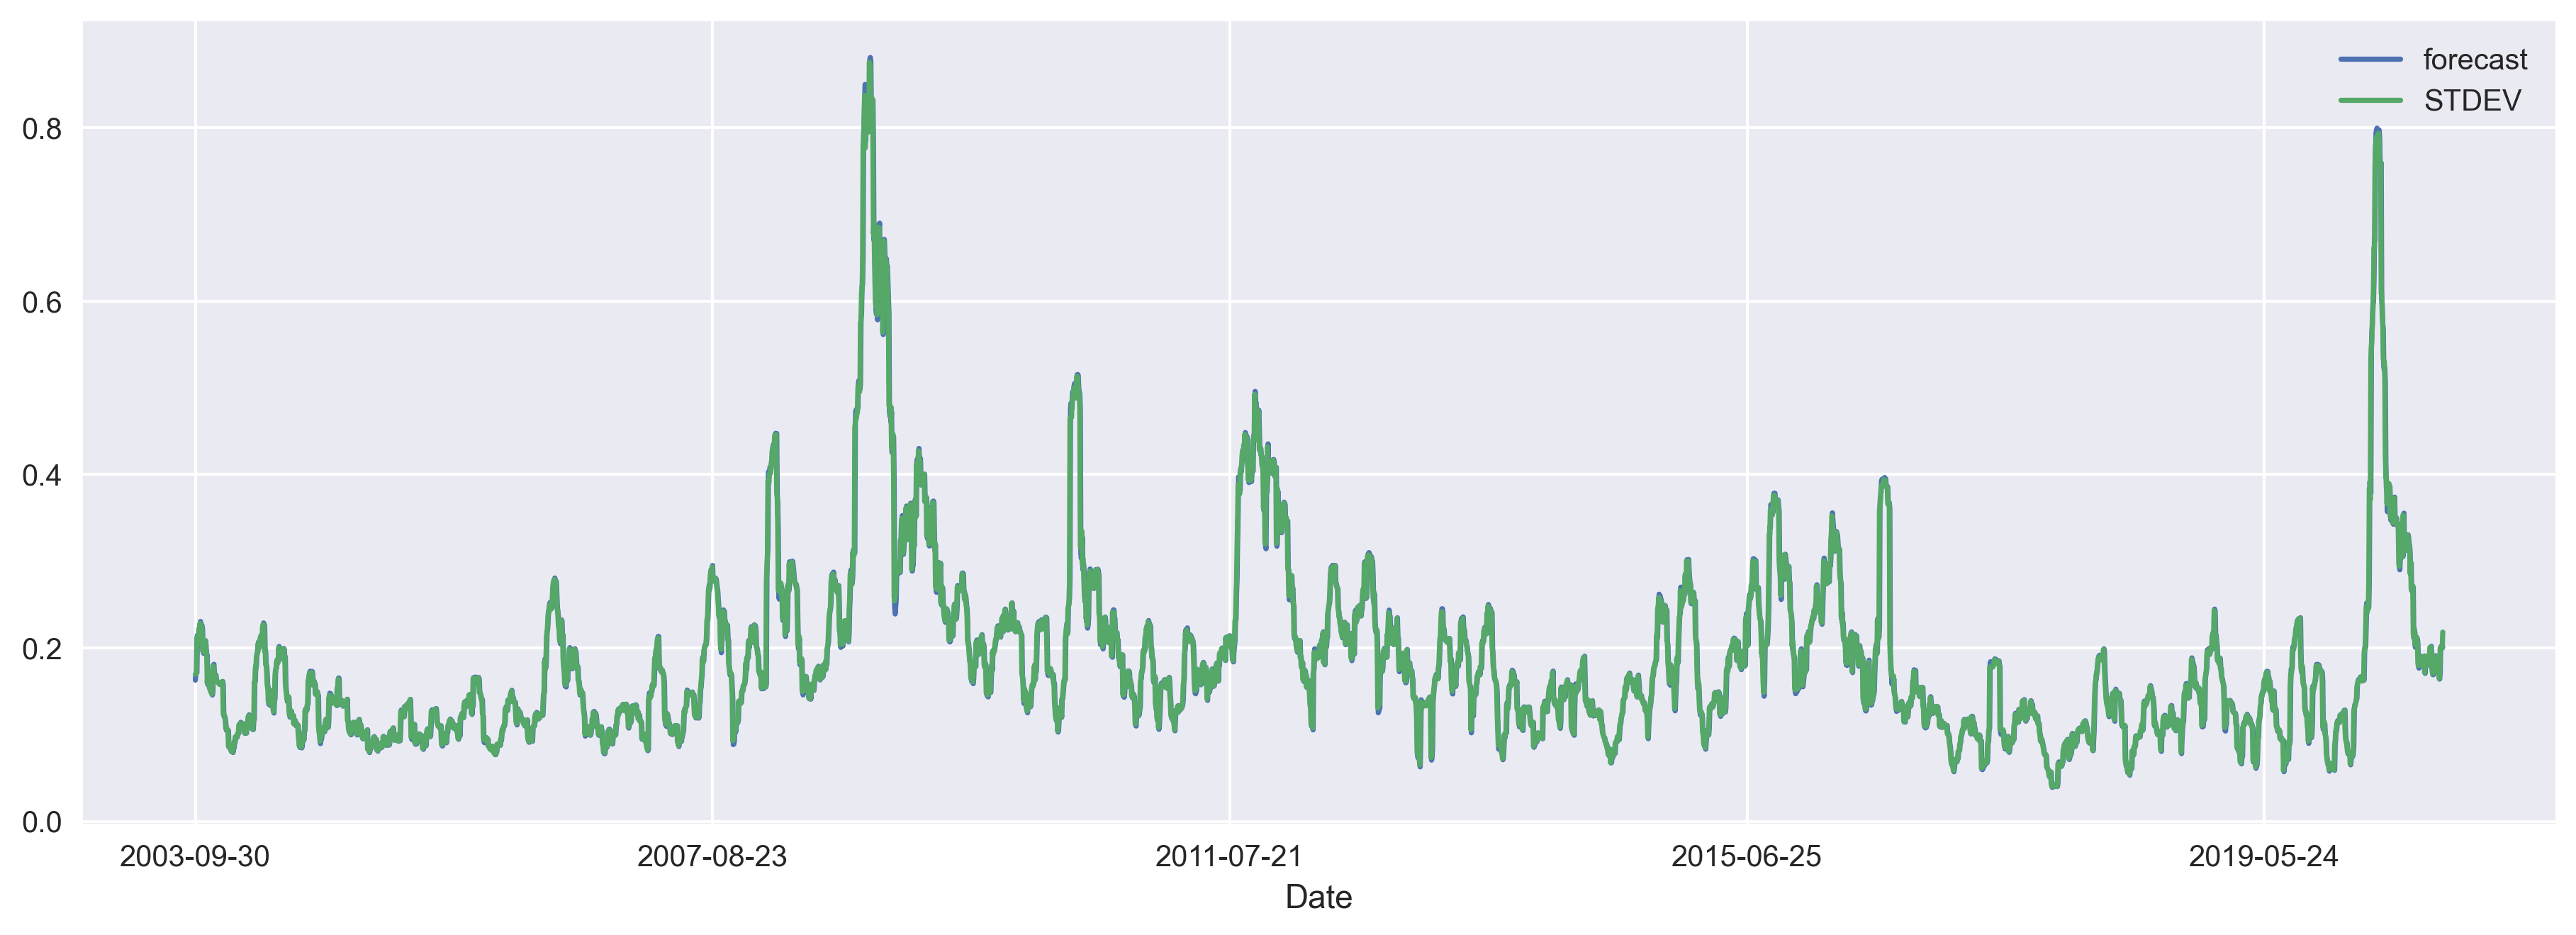

In [66]:
pig, ax = plt.subplots(figsize=(15,5))
arima_res.plot_predict(ax=ax)
plt.show()

# 1년치(2020-9-29 ~ 2021-9-28) 맞추기

In [67]:
forcast_result = arima_res.forecast(steps=257) # 245: 245일 맞춰봐 
# 예측값, stderr,   upper bound~lower bound
forcast_result = forcast_result[0]
print(forcast_result)

[0.21968434 0.22177661 0.22352545 0.22503275 0.22632955 0.2274458
 0.22840703 0.22923517 0.22994905 0.23056483 0.23109639 0.23155565
 0.23195282 0.2322967  0.23259481 0.23285365 0.23307875 0.2332749
 0.23344619 0.23359613 0.23372775 0.23384364 0.23394602 0.23403681
 0.23411763 0.23418992 0.23425486 0.2343135  0.23436673 0.23441532
 0.23445993 0.23450111 0.23453935 0.23457507 0.23460862 0.23464031
 0.23467041 0.23469913 0.23472668 0.23475322 0.23477889 0.23480381
 0.2348281  0.23485183 0.2348751  0.23489796 0.23492047 0.23494269
 0.23496465 0.23498639 0.23500794 0.23502933 0.23505058 0.23507171
 0.23509273 0.23511367 0.23513454 0.23515534 0.23517608 0.23519678
 0.23521743 0.23523805 0.23525864 0.2352792  0.23529974 0.23532026
 0.23534077 0.23536126 0.23538174 0.23540221 0.23542267 0.23544312
 0.23546356 0.235484   0.23550444 0.23552487 0.2355453  0.23556572
 0.23558614 0.23560656 0.23562698 0.23564739 0.23566781 0.23568822
 0.23570863 0.23572904 0.23574945 0.23576986 0.23579027 0.235810

In [68]:
len(forcast_result)

257

In [69]:
real = np.array(test_df['STDEV'])
real

array([0.21827526, 0.20560438, 0.20670064, 0.20508505, 0.19686318,
       0.19080536, 0.18279722, 0.18457689, 0.18656885, 0.18781403,
       0.18828359, 0.18806756, 0.20008734, 0.21109238, 0.15936463,
       0.15882157, 0.16869476, 0.16552251, 0.16717632, 0.16147084,
       0.17298922, 0.20806771, 0.20674401, 0.20849523, 0.22076844,
       0.23875296, 0.25474911, 0.25754209, 0.25713638, 0.37128785,
       0.37151728, 0.37083766, 0.36585156, 0.36160135, 0.36400949,
       0.3630003 , 0.35457122, 0.35687467, 0.35631511, 0.34505186,
       0.33293018, 0.29501444, 0.2952492 , 0.29519535, 0.30421763,
       0.29855757, 0.29287124, 0.29330315, 0.29071462, 0.13552186,
       0.12683017, 0.1268016 , 0.11165364, 0.11623338, 0.10086467,
       0.10069312, 0.09967173, 0.09616702, 0.09671318, 0.13046561,
       0.13262541, 0.13888736, 0.13889789, 0.14429852, 0.13479592,
       0.12920251, 0.13289148, 0.13507216, 0.13398441, 0.13868698,
       0.14006618, 0.140735  , 0.14451102, 0.14142009, 0.14117

In [70]:
len(real)

257

# RMSE 확인

In [71]:
from sklearn.metrics import mean_squared_error

mean_squared_error(real, forcast_result, squared=False)

0.10651723217234496